# Churn - ML Model Interpretation

## Set-up

Initializing environment

### Autoreload
Python magic to update source (src) libraries without restarting the kernel or importing.

In [1]:
%load_ext autoreload
%autoreload 2

### Set Up Environment
Importing libraries from both the conda environment and locally. Also prepping notebook-wide variables such as brand colours, and initialising plotting engines & parameters.

In [2]:
model = 'iplayer'

In [3]:
# Admin things
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from time import time
import pickle

# Number things
import pandas as pd
import numpy as np
import math
from scipy import interp

# Picture things
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

# Machine learning things
import shap

%matplotlib inline

# My things
from src import utils
from src import fi

# BBC colours
bbc = {'r':'#850200',
          'b':'#156E90',
          'y':'#F79B14',
          'o':'#F74B3A',
          'g':'#00A878',
          'dg':'#026A4C'}

bbc_hsl = {'r':0.9,
          'b':196.59,
          'y':35.68,
          'o':5.4,
          'g':162.6,
          'dg':162.6}

my_cmap = sns.diverging_palette(
    bbc_hsl['r'], bbc_hsl['b'], s=80, l=50, center='light',
    as_cmap=True
)


# Environmental params
# plt.style.use('dark_background')
# sns.set(style='darkgrid')
jtplot.style('grade3')

# load JS visualization code to notebook
shap.initjs()

# Directories
pickle_dir = 'pickles/'+model

# Plot distibutions of variables? Slow on large datasets
plot_distributions = False

In [4]:
stacker = utils.unpickle(pickle_dir+'/sample_stack.pickle')
pd.DataFrame(stacker.fi_dict['little_lgbm'].importances.mean(1))

FileNotFoundError: [Errno 2] No such file or directory: 'pickles/iplayer/sample_stack.pickle'

In [ ]:
?pd.DataFrame.to_csv

In [ ]:
['Fold '+str(x) for x in range(0, 10)]

In [ ]:
(df_X
            .query('target_week_start_date == @target_dates[0]')
#             .drop('target_week_start_date', axis=1)
            .head(5)
        )

## Loading feature importance data
Generated during model training, see churn-train.ipynb

In [15]:
# Unpack model interpretation ingredients (see churn-train.ipynb)
with open(pickle_dir+'/fi/little_fi.pickle', 'rb') as input_file:
    fi_dict = pickle.load(input_file)
    
# Unpack model interpretation ingredients (see churn-train.ipynb)
with open(pickle_dir+'/perf/blender_fi.pickle', 'rb') as input_file:
    blend_fi = pickle.load(input_file)

## Model Architecture

The model ensemble consists of:
* **Weak learners**:
    * **Logistic Regressions**:
        * event_logr
        * index_logr
        * cherry_logr
        * rfe_logr
    * **Gradient Boosters**:
        * big_lgbm
* **Meta-learner**:
    * Logistic regression on meta-features

## Meta-learner importance
The relative importance of the weak-learners to the final model predictions.

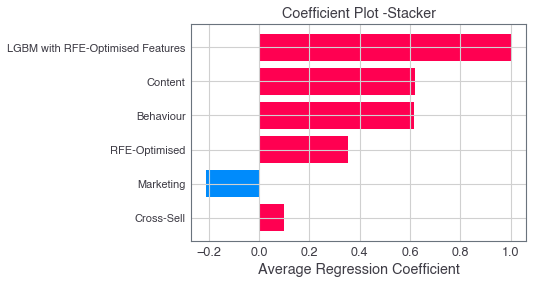

In [16]:
blend_fi.coeff_plot()

## Logistic Regression Model Interpretation
Logistic regression weak learners:
* event_logr
* index_logr
* cherry_logr
* rfe_logr

### Co-efficients
Absolute value and direction (positive/negative) of co-efficients in the logistic regression fit.

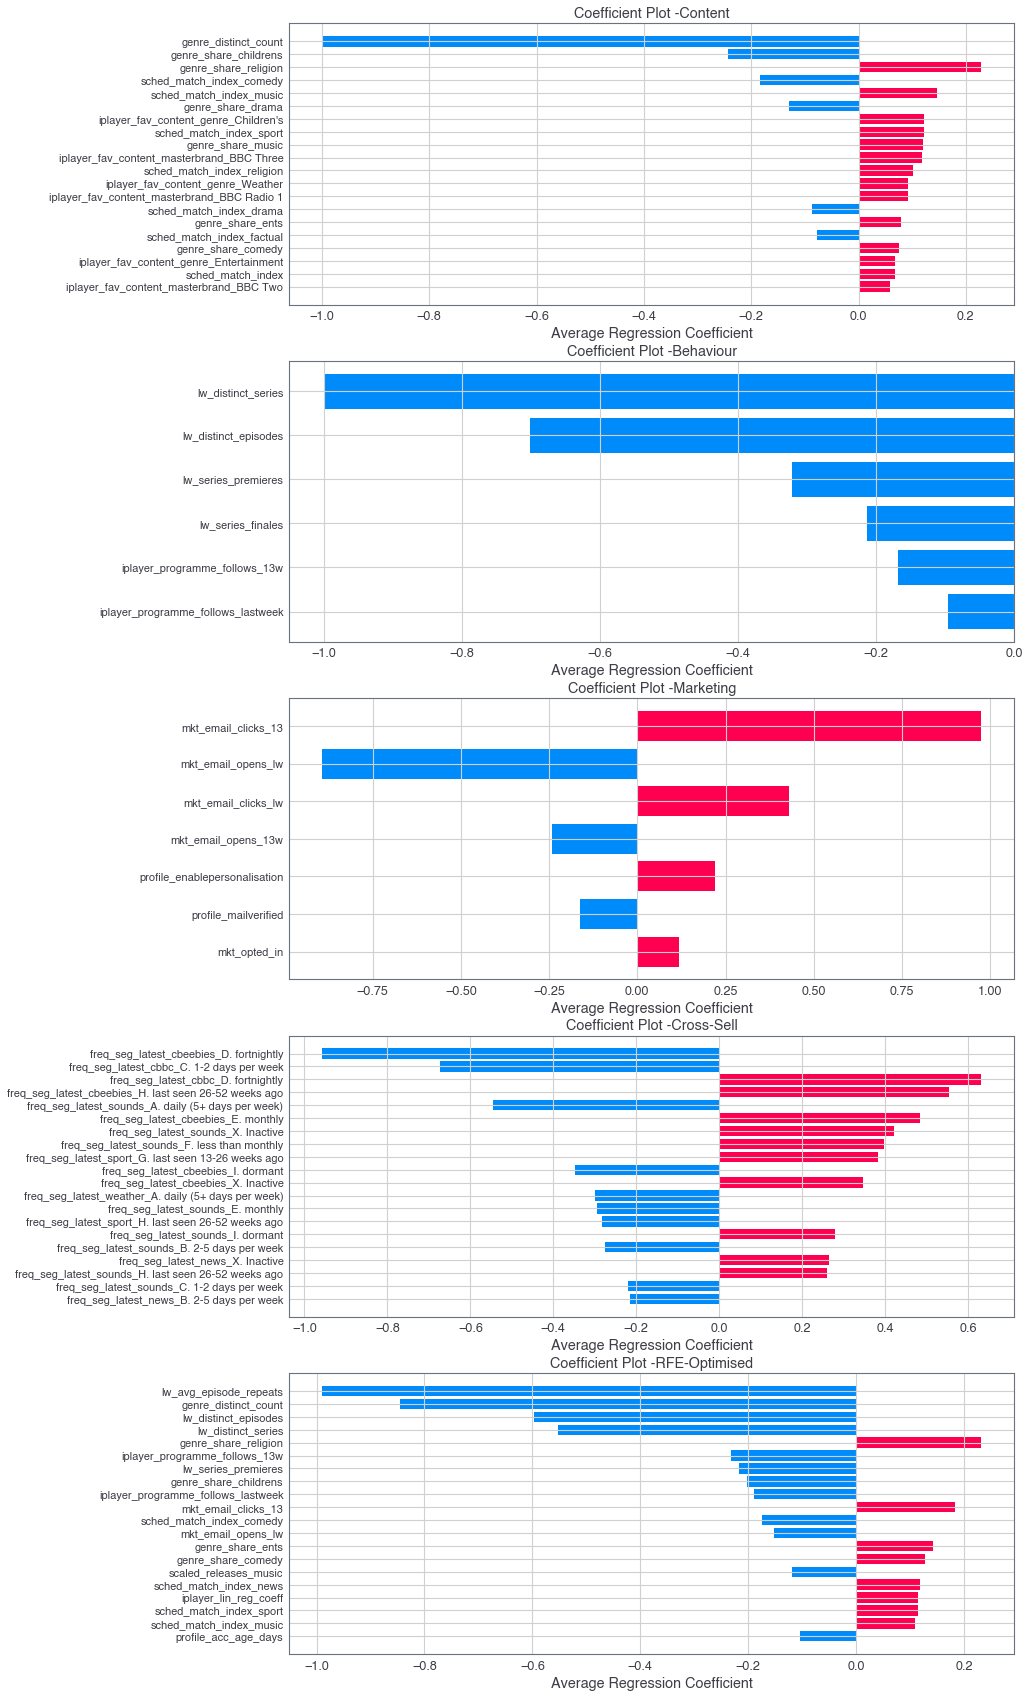

In [17]:
plt.figure(figsize=(13, 30))

k = 1
for fi in fi_dict.values():
    if fi.model_type == 'logr':
        plt.subplot(5,1,k)
        fi.coeff_plot()
        k += 1

In [ ]:
k = 1
for fi in fi_dict.values():
    if fi.model_type == 'logr':
        n_show=30
        importance = -(fi.coeffs_array.mean(1))
        # Ordering by importance & creating axis vals
        n_show = min(len(importance), n_show)
        idx = np.argsort(-importance)[:n_show:1]
        pos = np.arange(idx.shape[0]) + .5
        pd.DataFrame(importance[idx], columns=['coeff'], index=np.array(fi.colnames)[idx]).to_csv('data/fi/'+fi.name+'.csv')
#         print(importance)

In [ ]:
?pd.DataFrame.to_csv

## lightGBM Model Interpretation
_lightGBM is an excellent implementation of gradient-boosting designed by microsoft, more information here: [lightGBM](https://lightgbm.readthedocs.io/en/latest/)_ <br><br>

lightGBM weak learners:
* big_lgbm
<br><br>

### A note on Shapley values and SHAP

Gradient-boosted models, like most ensemble models or deep-learners, are famously hard to intepret black-box algorithms. Feature importance is generally measured by one or all of the following:
* Weight: Number of times a feature is used to split
* Cover: Number of times a feature is used to split, weighted by the number of data points in each split
* Gain: Loss reduction gained when using adding the feature to the model.<br>

These methods are not consistent and often disagree with one another. (See the introduction to SHAP with XGBoost from Scott Lundberg - co-creater of the SHAP algorithm - for more detail on why this is the case, and the motivation for the SHAP algorithm.)<br>

Shapley values are proposed as a solution to model interpretation, with roots in game theory (fantastic explanation [here](https://christophm.github.io/interpretable-ml-book/shapley.html)). The Shapley value for a feature at a datapoint is a measure of that feature's contribution to the model prediction. TreeSHAP is an algorithm design to find exact Shapley values for tree-based learners.<br>

The following visualisations use SHAP values from the TreeSHAP algorithm as a measure of the impact of a feature on the model prediction. The higher the absolute value, the larger the impact. Positive or negative values equate to positive or negative impacts on the model score.

It's also worth noting the SHAP values are **additive**. <br>(SHAP stands for **SH**apley **A**dditive ex**P**lanations. More detail in the Shapley value explanation above)

### big_lgbm
A kitchen-sink model, taking a large number (~100) of the most predictive features and throwing them all at a lightGBM model.

#### Force plots
The combined effect of multiple features to create a prediction on a single (randomly selected) data point.

In [ ]:
fi_dict['big_lgbm'].random_force_plot(fold = 0)

In [ ]:
fi_dict['big_lgbm'].random_force_plot(fold = 0)

Force plots given anecdotal information on how features can work together to come to a final model score for an individual. 

#### Global force plots
Taking the force plots together for every row in the dataset, and laying them together side-by-side gives a perspective on how the model scores similar individuals in similar ways:

In [20]:
fi_dict['LGBM with RFE-Optimised Features'].global_force_plot(fold = 0, maxplotsize=100)

#### Feature Summary Plot
For each feature we can compare the distributions of SHAP values to observe the scale of impact on the model predictions from each feature. Plotting the feature values on the colour scale also gives an indication on whether it's high or low feature values driving these SHAP values. SHAP values further away from the zero-line have a larger impact. 

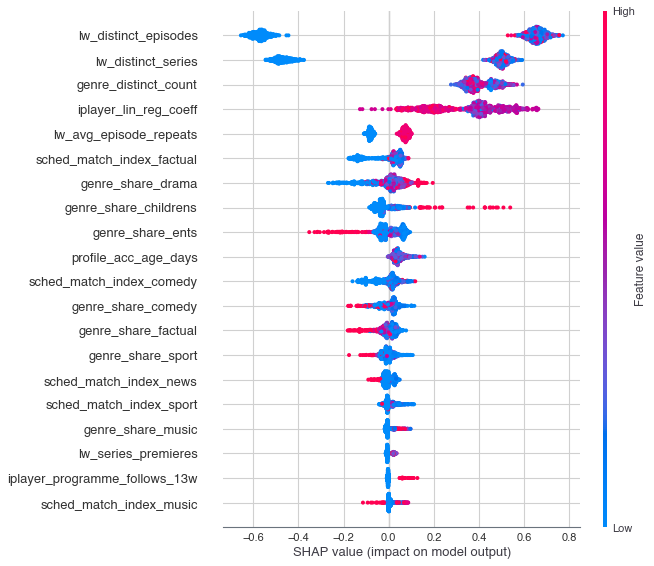

In [19]:
fi_dict['LGBM with RFE-Optimised Features'].summary_plot(title = 'Feature impact on lightGBM model predictions')

Some observations on the above:

[ observations ]
<br><br>
    
 Taking the mean absolute SHAP value as an estimation of the average impact of a feature on the model prediction:

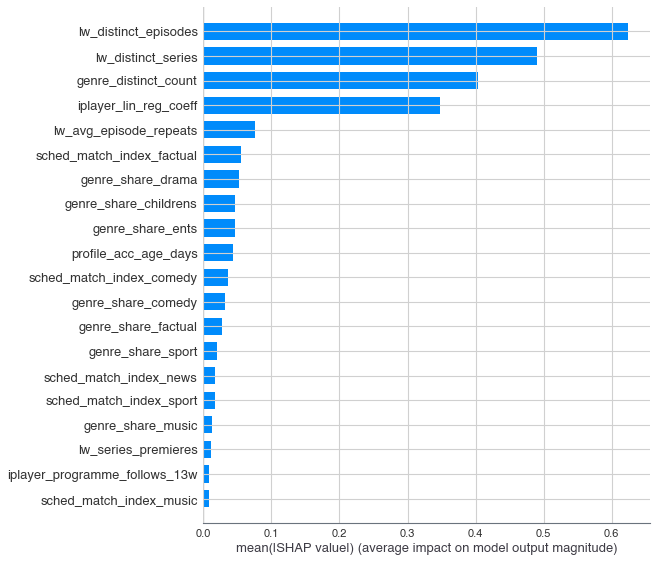

In [21]:
fi_dict['LGBM with RFE-Optimised Features'].fi_plot()

#### Individual feature dependency plots:

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)

fi_dict['index_lgbm'].feature_dependence_plot(
    'sched_match_index_ents',
    color = '#ff4800', dot_size = 30,
    interaction=None,
    title = 'Time since activation',
    ax=ax
)

In [ ]:
# fig.savefig('./charts/fd-sounds-time-since-activation')

In [ ]:
# my_cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
fi_dict['little_lgbm'].decision_plot(fold=0, supersample_frac = .02,
                                  feature_display_range = slice(-1, -101, -1))

### explorer_lgbm
LGBM model for exploring the relative importance of some representative variables for each feature group

#### Feature Summary Plot

In [ ]:
fi_dict['explorer_lgbm'].summary_plot(title = 'Feature impact on lightGBM model predictions')

Some observations on the above:

[ observations ]
<br><br>
    
 Taking the mean absolute SHAP value as an estimation of the average impact of a feature on the model prediction:

In [ ]:
fi_dict['explorer_lgbm'].fi_plot()

#### Individual feature dependency plots:

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

feature = 'genre_st_factual'
feature_group = ''
feature_name = ''

fi_dict['little_lgbm'].feature_dependence_plot(
    feature,
    color = '#f54997', dot_size = 30,
    interaction=None,
    title = feature_group+' - '+feature_name,
    ax=ax,
    show=False
)

ax.set_ylabel('')
ax.set_xlabel('')
ax.axhline()
plt.show();

In [ ]:
# fig.savefig('./charts/fd-iplayer-watch_list', dpi = 300)

In [ ]:
# my_cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
fi_dict['explorer_lgbm'].decision_plot(fold=0, supersample_frac = .02,
                                  feature_display_range = slice(-1, -101, -1))